## Introduction

This notebook demonstrates how the performance metrics for openWakeWord models are calculated, specifically the false-reject and false-accept rates based on testing datasets of WAV files.

Note that calculating these metrics often involves some degree of subjectivity. In particular, choices around how to count false-reject and false-accepts can have a large impact on the resulting metrics. For openWakeWord, the following choices were made:

- False-reject counts are based on individual clips that contain a *single* positive example. If the score for any frame in that clip is above a threshold, it counts as a true-accept for that clip.
- False-accept counts are also based on counts of frame scores above a threshold. *However*, to avoid double-counting, some basic filtering is applied to the time-series of frame scores to ensure that each false activation is only counted once. See the `openwakeword.metrics.get_false_positives` function for more details, but in short, after a single frame above the threshold the subsequent 50 frames (4 seconds) are ignored before another false activation will be counted.

In [1]:
# Imports

import os
import platform

import numpy as np
from pathlib import Path
import IPython.display as ipd
import matplotlib.pyplot as plt

import openwakeword
from openwakeword.utils import bulk_predict
from openwakeword.metrics import get_false_positives


# Download Dataset(s)

In [ ]:
# Download and extract DipCo corpus (warning! This is 12GB)

if platform.system() == "Linux":
    !wget https://s3.amazonaws.com/dipco/DiPCo.tgz
else:
    !curl -O https://s3.amazonaws.com/dipco/DiPCo.tgz

!tar -zxf DipCo.tgz

#### Links for some useful testing data

Picovoice "alexa" dataset: https://github.com/Picovoice/wake-word-benchmark/tree/master/audio/alexa

Note that some files (like the "alexa" dataset) will need to be converted to 16 khz, 16-bit wav files.
You can use the `openwakeword.data.convert_clips` utility function to do so, which requires either `sox` or `ffmpeg` as the system-level backend.

# Load Trained openWakeWord Model(s)

In [3]:
# Load a trained openWakeWord models

model_path = "../openwakeword/resources/models/alexa_v0.1.onnx"
model_name = "alexa_v0.1"
oww = openwakeword.Model(
    wakeword_model_paths=[model_path]
)

/home/dscripka/anaconda3/envs/torch_gpu/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:54: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


# Estimate False accept rate/false positive rate

In [4]:
# Get paths to test files (DipCo corpus)

clips = [str(i) for i in Path("DiPCo/audio/").glob("**/*U01.CH1.wav")]

# Do bulk prediction in parrallel for faster inference
predictions = bulk_predict(
    file_paths = clips,
    wakeword_model_paths=[model_path],
    ncpu=10 # set this to the number of CPU cores you have available
)

# Flatten predictions into a single list, as we don't need to differentiate between files for this test
predictions_dipco = [i[model_name] for j in predictions.keys() for i in predictions[j]]


In [5]:
# Calculate the number of false positives

num_false_positives = get_false_positives(predictions_dipco, threshold=0.5, grouping_window=50)
num_false_positives

16

(0.0, 1.0)

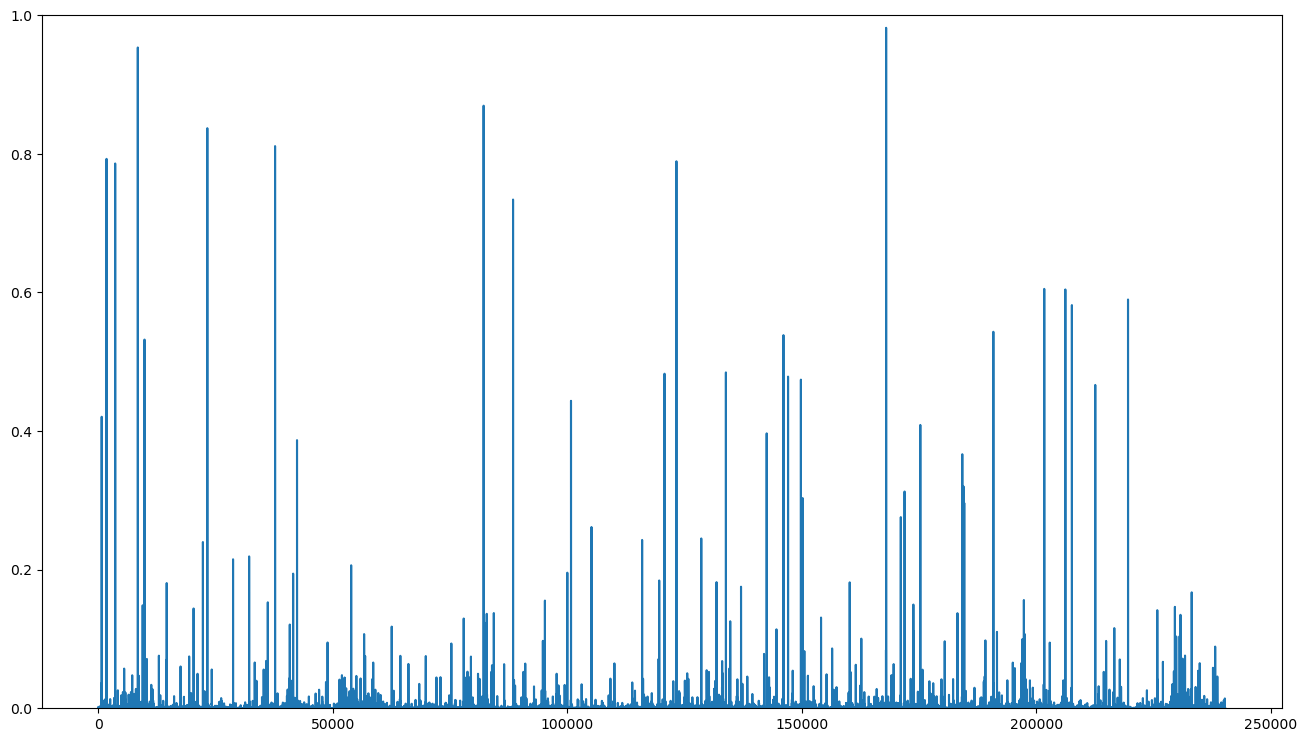

In [6]:
# Plot results
plt.figure(figsize=(16,9))
plt.plot(predictions_dipco)
plt.ylim(0,1)

# False reject rate/false negative rate

In [7]:
# Get paths to test files (positive examples)

clips = [str(i) for i in Path("alexa_test_clips/").glob("**/*.wav")] # assumes these clips are 16khz, 16-bit WAV files

# Do bulk prediction for faster testing
predictions_frr = bulk_predict(
    file_paths = clips,
    wakeword_model_paths=[model_path],
    ncpu=10,
    padding=2 # pad each clip with n seconds of silence before & after
)

# Count how many files had a prediction above a given threshold
threshold = 0.5
fn = 0
fn_clips = []
positive_scores = []
for fname, scores in predictions_frr.items():
    scores = [i[model_name] for i in scores]
    positive_scores.append(max(scores))
    if positive_scores[-1] < threshold:
        fn += 1
        fn_clips.append(fname)

print(f"False Reject Rate @{threshold} threshold: {fn/len(clips)}")

False Reject Rate @0.5 threshold: 0.030395136778115502


In [ ]:
# (optionally) listen to the falsely rejected clips

for i in fn_clips:
    sr, dat = scipy.io.wavfile.read(i)
    ipd.display(ipd.Audio(dat, rate=16000, normalize=True, autoplay=False))


# Plot False-Acccept/False-Reject Curve

100%|██████████| 50/50 [00:00<00:00, 41734.37it/s]


Text(0, 0.5, 'False Reject Rate')

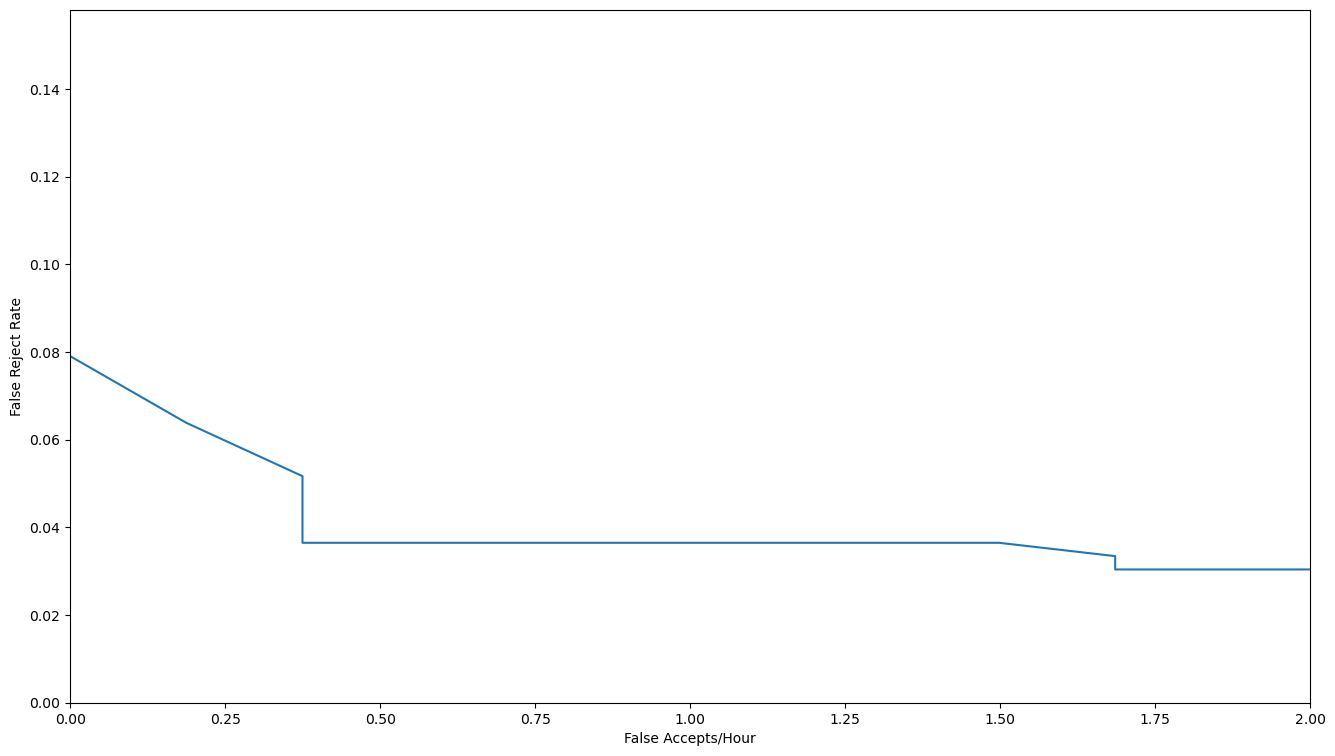

In [9]:
# Compute and plot the false-accept/false-reject curve from the metrics above (requires that all cells have been run)

from openwakeword.metrics import generate_roc_curve_fprs, generate_roc_curve_tprs

fprs = generate_roc_curve_fprs(predictions_dipco, n_points=50)
tprs = generate_roc_curve_tprs(positive_scores, n_points=50)
frr = [1 - i for i in tprs]

# Make plot
plt.figure(figsize=(16,9))
plt.plot(fprs, frr)
plt.ylim(0,max(frr)*2)
plt.xlim(0,2)
plt.xlabel("False Accepts/Hour")
plt.ylabel("False Reject Rate")
